<a href="https://colab.research.google.com/github/dancher00/eeml2025/blob/main/Basic_PyTorch_(MLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to PyTorch: Building a Multi-Layer Perceptron (MLP)

**Authors**:
* Mandana Samiei (samieima@mila.quebec)
* Teodor Szente (teosz@google.com)

This notebook is designed to teach the basics of PyTorch by building a Multi-Layer Perceptron (MLP).

## Setup

The first cell imports the necessary libraries and sets up the environment for training the MLP.

Imports:
- torch: The main PyTorch library for building and training neural networks.
- torch.nn: A submodule of PyTorch containing neural network components like layers and loss functions.
- torch.optim: A submodule of PyTorch containing optimization algorithms like SGD, Adam, etc.
- torchvision: A PyTorch package containing popular datasets, model architectures, and image transformations.
- matplotlib.pyplot: A plotting library used for visualizing data and model performance.

Check if CUDA is available:
- We check if a CUDA-enabled GPU is available. If it is, we set the device to 'cuda'; otherwise, we set it to 'cpu'.
- Using a GPU can significantly speed up the training process for large neural networks.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Check if CUDA is available and set device to GPU if it is
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Preparation

This cell handles the preparation and loading of the MNIST dataset, which is used for training and testing the MLP model.

**Transformations**:
- We define a transformation to apply to the images:
  - transforms.ToTensor(): Converts the image to a PyTorch tensor.
  - transforms.Normalize((0.5,), (0.5,)): Normalizes the image tensor with mean and standard deviation of 0.5. This scales the pixel values to the range [-1, 1].

**Datasets**:
- train_dataset: Downloads and loads the MNIST training set, applying the defined transformations.
- test_dataset: Downloads and loads the MNIST test set, applying the defined transformations.

**Data Loaders**:
- train_loader: Creates a DataLoader for the training dataset with a batch size of 64 and shuffling enabled.
  - Shuffling ensures that the model does not learn the order of the data and improves generalization.
- test_loader: Creates a DataLoader for the test dataset with a batch size of 64 and shuffling disabled.
  - No shuffling for the test set as we want to evaluate the model on the same order of data each time for consistency.


In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load training and test sets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.07MB/s]


## Model Definition

This cell defines and initializes a simple Multi-Layer Perceptron (MLP) model for classifying MNIST images.

MLP Class:
- A subclass of nn.Module.
- __init__ Method:
  - Initializes the MLP with one hidden layer of 128 neurons and an output layer of 10 neurons.
  - nn.Linear(784, 128): Input layer with 784 input features (28x28 pixels) and 128 output features.
  - nn.ReLU(): Applies the ReLU activation function to introduce non-linearity.
  - nn.Linear(128, 10): Output layer with 128 input features and 10 output features (one for each class).

- forward Method:
  - Defines the forward pass of the network.
  - x.view(x.size(0), -1): Flattens the input tensor to a 2D tensor with shape (batch_size, 784).
  - return self.layers(x): Passes the input through the layers defined in __init__ and returns the output.

Model Initialization:
- Creates an instance of the MLP class and moves it to the appropriate device (GPU or CPU) for training.


In [5]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 128),  # Input layer (28*28 = 784)
            nn.ReLU(),
            nn.Linear(128, 10)   # Output layer (10 classes)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        return self.layers(x)

# Create the model and move it to the appropriate device
model = MLP().to(device)


## Training the Model
Now, let's define the loss function and optimizer, and start training the model.

**Loss Function and Optimizer:**
- criterion = nn.CrossEntropyLoss(): Defines the loss function as Cross-Entropy Loss, commonly used for classification tasks.
- optimizer = optim.Adam(model.parameters(), lr=0.001): Sets up the Adam optimizer with a learning rate of 0.001 to update the model parameters.

**Training Function:**
- train(model, device, train_loader, optimizer, criterion): Trains the model for one epoch.
  - **model.train()**: Sets the model to training mode, enabling features like dropout and batch normalization.
  - **for batch_idx, (data, target) in enumerate(train_loader)**: Iterates over the training dataset in batches.
  - **data, target = data.to(device), target.to(device)**: Moves the data and target tensors to the specified device (CPU or GPU).
  - **optimizer.zero_grad()**: Clears the gradients of all optimized tensors to prepare for the next backward pass.
  - output = model(data): Performs a forward pass through the model to compute predictions.
  - **loss = criterion(output, target)**: Computes the loss between the predictions and the true targets.
  - **loss.backward()**: Performs a backward pass to compute the gradients of the loss with respect to model parameters.
  -**optimizer.step()**: Updates the model parameters based on the computed gradients.

**Training Loop:**
- for epoch in range(10): Trains the model for 10 epochs.
  - **train(model, device, train_loader, optimizer, criterion)**: Calls the train function to train the model for one epoch.
  - **print(f'Epoch {epoch+1} complete.')**: Prints a message indicating the completion of each epoch.

This setup allows the neural network to learn from the training data by minimizing the loss function and updating its parameters using the Adam optimizer.



In [6]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print('Train loss=', loss.item())

# Train the model
for epoch in range(10):
    train(model, device, train_loader, optimizer, criterion)
    print(f'Epoch {epoch+1} complete.')

Train loss= 0.11769510805606842
Epoch 1 complete.
Train loss= 0.12861032783985138
Epoch 2 complete.
Train loss= 0.20895634591579437
Epoch 3 complete.
Train loss= 0.053569722920656204
Epoch 4 complete.
Train loss= 0.009622877463698387
Epoch 5 complete.
Train loss= 0.023027734830975533
Epoch 6 complete.
Train loss= 0.09517846256494522
Epoch 7 complete.
Train loss= 0.008363577537238598
Epoch 8 complete.
Train loss= 0.14522860944271088
Epoch 9 complete.
Train loss= 0.023331157863140106
Epoch 10 complete.


## Model Evaluation
Finally, evaluate the model's performance on the test dataset.

Function: evaluate
- **Args**:
  - model (torch.nn.Module): The neural network model to evaluate.
  - device (torch.device): The device (CPU or GPU) to perform evaluation on.
  - test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
  - criterion (torch.nn.Module): Loss function to use for evaluation.

- **Returns**:
  - list: List of batch loss values recorded during evaluation.
  - list: List of batch accuracy values recorded during evaluation.

- **Functionality**:
  - model.eval(): Sets the model to evaluation mode, disabling certain layers like dropout and batch normalization that behave differently during training.
  - with torch.no_grad(): Disables gradient computation, reducing memory consumption and speeding up the evaluation process.
  - For each batch in the test_loader:
    - Move the data and target tensors to the specified device (CPU or GPU).
    - Perform a forward pass to compute the model's output.
    - Compute the loss using the criterion and accumulate it.
    - Determine the predicted class by finding the index of the maximum log-probability.
    - Compare the predictions to the true targets and accumulate the number of correct predictions.
    - Calculate and store the accuracy for each batch.
  - Calculate the overall accuracy and average loss across all batches.
  - Print the overall test accuracy and average loss.

Usage:
- Call this function with your model, device, test_loader, and criterion to evaluate the model's performance on the test dataset.
- Use the returned batch losses and accuracies for plotting or further analysis.


In [7]:
import matplotlib.pyplot as plt
import torch

def evaluate(model, device, test_loader):
    """
    Evaluate the performance of the model on the given test data loader.

    Args:
        model (torch.nn.Module): The model to evaluate.
        device (torch.device): Device to perform evaluation on (CPU or GPU).
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.

    Returns:
        float: Accuracy over the test dataset.
    """
    model.eval()
    total_correct = 0
    batch_accuracies = []
    total_loss = 0.0
    batch_losses = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss = criterion(output, target)
            total_loss += loss.item()
            batch_losses.append(loss.item())

            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            total_correct += pred.eq(target.view_as(pred)).sum().item()

            # Calculate batch accuracy and store it
            batch_accuracy = pred.eq(target.view_as(pred)).sum().item() / data.size(0)
            batch_accuracies.append(batch_accuracy * 100)

    accuracy = total_correct / len(test_loader.dataset)
    average_loss = total_loss / len(test_loader)

    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Test Loss: {average_loss:.4f}')

    return batch_losses, batch_accuracies

Performance Visualization:
This cell defines a function `visualize_performance` that takes in lists of batch losses and accuracies and plots them.

Function: visualize_performance
- Args:
  - batch_losses (list): A list of loss values recorded for each batch during training.
  - batch_accuracies (list): A list of accuracy values recorded for each batch during training.

- Functionality:
  - This function creates two subplots side by side:
    1. Batch Loss Plot:
      - X-axis: Batch number
      - Y-axis: Loss value
      - A line plot of the loss values over the batches with a green line.
    2. Batch Accuracy Plot:
      - X-axis: Batch number
      - Y-axis: Accuracy percentage
      - A line plot of the accuracy values over the batches with a blue line.
  - Both plots include labels for the axes, titles, legends, and grid lines for better readability.
  - The function uses `plt.tight_layout()` to ensure that the subplots are neatly arranged without overlapping.
  - Finally, `plt.show()` is used to display the plots.

Usage:
- Call this function after training your model to visualize how the loss and accuracy changed over the batches.

In [8]:
def visualize_performance(batch_losses, batch_accuracies):

   # Plotting accuracy over time
    plt.figure(figsize=(16, 5))

    plt.subplot(1, 2, 1)
    plt.plot(batch_losses, label='Loss', color='g')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Batch Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(batch_accuracies, label='Accuracy',  color='b')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy (%)')
    plt.title('Batch Accuracy')
    plt.legend()
    plt.grid(True)


This cell smooths the loss and accuracy curves using a moving average with a window size of 5.

- smooth_window = 5: Defines the size of the moving average window.
- smoothed_losses: Computes the smoothed loss values by averaging over a window of 5 batches.
- smoothed_accuracies: Computes the smoothed accuracy values by averaging over a window of 5 batches.


In [9]:
import matplotlib.pyplot as plt
import torch

def smooth_visualization(batch_losses, batch_accuracies):

    # Smooth the loss and accuracy curves
    smooth_window = 5
    smoothed_losses = [sum(batch_losses[i:i+smooth_window])/smooth_window for i in range(len(batch_losses)-smooth_window+1)]
    smoothed_accuracies = [sum(batch_accuracies[i:i+smooth_window])/smooth_window for i in range(len(batch_accuracies)-smooth_window+1)]

    # Plotting loss and accuracy over time
    plt.figure(figsize=(13, 5))

    plt.subplot(1, 2, 1)
    plt.plot(smoothed_losses, label='Loss', color='g')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Smoothed Loss over Batches')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(smoothed_accuracies, label='Accuracy', color='b')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy (%)')
    plt.title('Smoothed Accuracy over Batches')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Test Accuracy: 97.05%
Test Loss: 0.1000


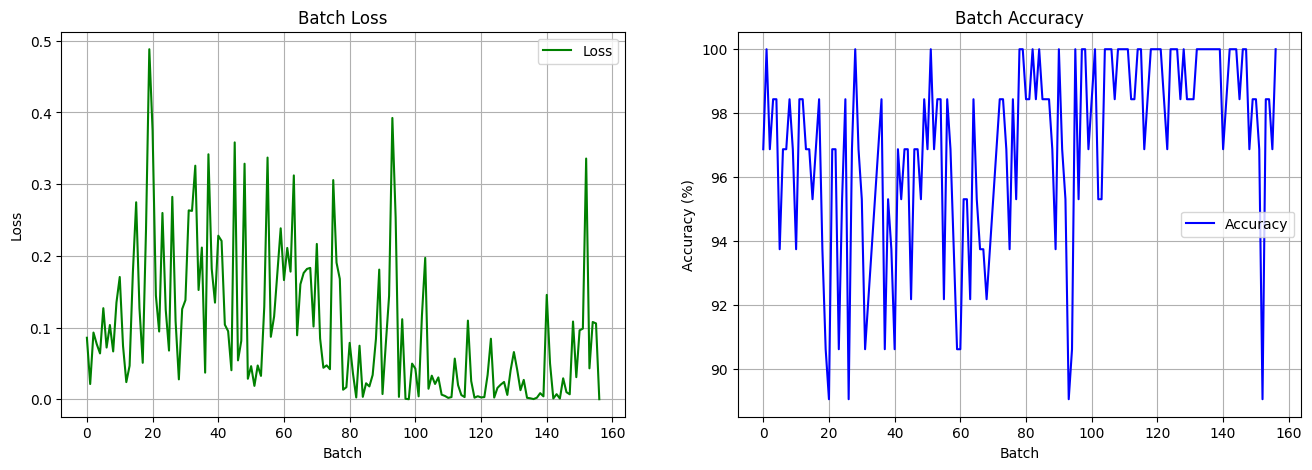

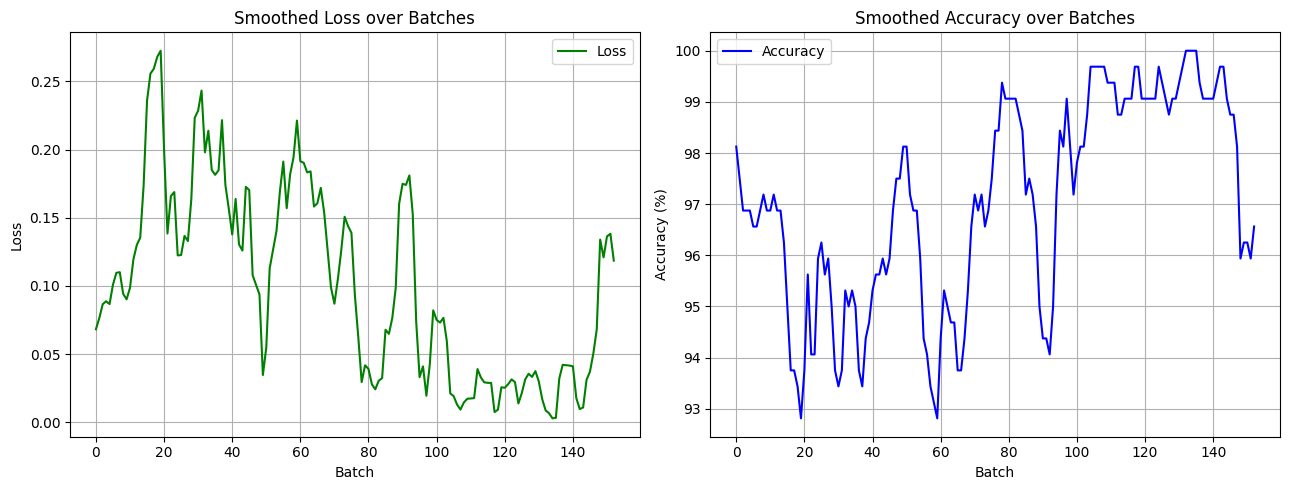

In [10]:
# Example usage:
# Evaluate the model
loss, accuracy = evaluate(model, device, test_loader)

# visualize the performance of the model during evaluation
visualize_performance(loss, accuracy)
smooth_visualization(loss, accuracy)

### Thanks for following the second introductory tutorial. You can check out the third one to learn more advanced subjects.